###  Data Entries: 
0 Bound, 1 Date + Time, 2 Seq No, 3 Lane, 4 Speed, 5 Class, 6 No of Axle, [ Axle Weight, Axle Spacing]

---
### <span style="color:red"> Methods and Procedures </span>


#### Data Cleaning
- Sort the data based on Date > Bound > lane   DONE
- obtain the gap distance    DONE

#### Fitting and Regression
- Find the daily average vehicle flow  DONE
- Find the Variation in Traffic flow across different times of the day DONE
- Find the variation in LDV:HDV ratio across different times of the day  GAVE UP
- Find the variation in (Traffic Volume in hour)/(Traffic Volume in day) across different times of the day [Reference](https://medium.com/hal24k-techblog/a-guide-to-generating-probability-distributions-with-neural-networks-ffc4efacd6a4) 
- Find the PDF of the vehicle weight of LDV  DONE 
- Find the PDF of the vehicle weight of HDV  DONE
- Find the Relation between parameters with the below methods  

#### Monte Carlo Simluation
- Set up an environment for simulation. Refer to your IR. 
- Run for 2400 years (USE SEED to make sure the value is same every time) -> maybe do it a few times and take the average?
- Obtain max load effect. -> Transition to SAP2000
- Then maybe measure the load effect with varying parameters to plot a 3d surface. (but what parameters should I vary with?)

---

### Relationship between each entries: 
 - Time of the day -> Proportion of Vehicle Class
   - Vehicle Class -> Vehicle Speed ? Need to see if there is a relationship or not. 
      - Vehicle Class + Vehicle Speed -> Gap Distance  
        //
   - Vehicle Class -> Axle Number 
      - Axle number -> Total Weight & Axle Weight

Multiple Lasso/Ridge Regression or polynomial regression would be used to draw the relationships of the above figures. 

### Assumptions and Relationships: 
- the Traffic composition relates to the time of the day
- Gap distance between vehicles is determined by the vehicle speed and the vehicle class ie. weight

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
all_data= pd.read_excel('output.xlsx')
# usecols='A:I'

In [5]:
len(all_data.index)

87502

#### Calculates the Gap distance

In [6]:
# all_data.loc[:,'Seq No':'Class'].head()
all_data['Date + Time'] = pd.to_datetime(all_data['Date + Time'])
all_data['Date'] = pd.to_datetime(all_data['Date + Time']).dt.date
all_data['Date'].unique()

all_data = all_data.sort_values(['Date','Bound', 'Lane','Seq No'])

all_data['Same Bound'] = all_data['Bound'] == all_data['Bound'].shift(1)
all_data['Same Lane'] = all_data['Lane'] == all_data['Lane'].shift(1)    
# if all_data.loc['Bound'].eq(all_data.loc['Bound'].shift(1)) and all_data.loc['Lane'].eq(all_data.loc['Lane'].shift(1)):
#     all_data['Gap Distance'] = all_data['Speed'] * (all_data['Date + Time'].shift(1) - all_data['Date + Time'])
# else:
#     all_data['Gap Distance'] = pd.NA

filter1 = all_data['Same Bound'] == True
filter2 = all_data['Same Lane'] == True
not_filter1 = all_data['Same Bound'] == False
not_filter2 = all_data['Same Lane'] == False

change = all_data['Date + Time'].diff().dt.seconds
# all_data['Speed'] * (all_data['Date + Time'].shift(1) - all_data['Date + Time'])

all_data.loc[filter1 & filter2, 'Gap Distance'] = change
all_data.loc[not_filter1, 'Gap Distance'] = pd.NA
all_data.loc[not_filter2, 'Gap Distance'] = pd.NA


# all_data = all_data.fillna(all_data['Gap Distance'].mean())

cols = ['Gap Distance']
all_data.loc[:,cols] = all_data.loc[:,cols].bfill()


/var/folders/py/yncddnwd6kn7d9dzfmz1kcbm0000gn/T/ipykernel_64224/3875649319.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  all_data['Date + Time'] = pd.to_datetime(all_data['Date + Time'])


In [7]:
subset = all_data.drop(columns=['Date + Time','Date']).loc[:,:'No of Axle']
Weight_Gap_Corr = subset.corr()
print(Weight_Gap_Corr)

              Gap Distance  Total Weight     Bound    Seq No      Lane   
Gap Distance      1.000000      0.046639 -0.112323  0.092324  0.043471  \
Total Weight      0.046639      1.000000 -0.031601  0.034114 -0.388749   
Bound            -0.112323     -0.031601  1.000000  0.038872  0.086363   
Seq No            0.092324      0.034114  0.038872  1.000000  0.042279   
Lane              0.043471     -0.388749  0.086363  0.042279  1.000000   
Speed             0.033896     -0.216113 -0.021953 -0.036410  0.401576   
Class             0.041409      0.764752 -0.022125  0.035003 -0.390537   
No of Axle        0.039531      0.827129 -0.024496  0.032235 -0.342704   

                 Speed     Class  No of Axle  
Gap Distance  0.033896  0.041409    0.039531  
Total Weight -0.216113  0.764752    0.827129  
Bound        -0.021953 -0.022125   -0.024496  
Seq No       -0.036410  0.035003    0.032235  
Lane          0.401576 -0.390537   -0.342704  
Speed         1.000000 -0.170976   -0.196007  
Clas

-------

It can be seen that there is not much relationship between Gap distace and Total Weight

There is relationship between speed and lane number, but should not affect the calculation of load effect. 


Class 1 - Motor cycles

Class 2 - Private cars


Class 3 - Light buses

Class 4 - Light Goods Vehicles

Class 5 - Medium Goods Vehicles

Class 6 - Rigid Heavy Goods Vehicles

Class 7 - Articulated Heavy Goods Vehicles

Class 8 - Buses and Coaches

Class 9 - Unclassified

## Average Vehicular Flow

In [8]:
date_list = all_data['Date'].unique()
avf_list = []
for date in date_list: 
    avf_list.append(round(len(all_data[all_data['Date']==date].index),2))
dict = {'Date': date_list, "Daily Vehicular Flow": avf_list}
AVFdf = pd.DataFrame(dict)
print(AVFdf)
mean_vf = AVFdf["Daily Vehicular Flow"].mean()
sd_vf = AVFdf["Daily Vehicular Flow"].std()
print(mean_vf, sd_vf)


         Date  Daily Vehicular Flow
0  2000-01-01                 21219
1  2000-08-23                  8882
2  2000-11-21                  6398
3  2000-11-22                  4771
4  2004-12-30                 46232
17500.4 17312.643885322657


[array([82, 76, 76, ..., 99, 84, 91]), array([63, 72, 72, ..., 88, 94, 86]), array([74, 74, 78, ..., 88, 88, 88]), array([72, 69, 69, ..., 91, 78, 79]), array([86, 74, 63, ..., 82, 79, 82])]


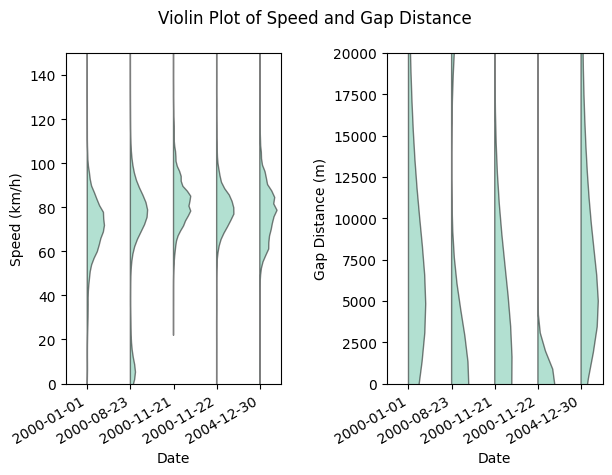

In [9]:
from statsmodels.graphics.boxplots import violinplot

# df = pd.DataFrame(np.random.rand(7, 100), columns=['y']*100)
# df.index = pd.date_range(datetime.today(), periods=7).tolist()
# df
speed_list = []
gap_list = []
for date in date_list:
    speed_list.append(np.array(all_data[all_data['Date']==date]['Speed']))
    gap_list.append(np.array(all_data[all_data['Date']==date]['Gap Distance']))
print(speed_list)
fig, (ax1, ax2) = plt.subplots(1,2)
violinplot(data=speed_list, ax=ax1, labels=date_list, side='right', show_boxplot=False)
violinplot(data=gap_list, ax=ax2, labels=date_list, side='right', show_boxplot=False)
# plt.xlabel('Date')
# plt.ylabel('Speed (km/h)')
plt.setp(ax1, ylim=[0,150], xlabel = 'Date', ylabel = 'Speed (km/h)')
# plt.setp(ax2, ylim=[0,20000], xlabel = 'Date', ylabel = 'Gap Distance (m)')
plt.suptitle('Violin Plot of Speed and Gap Distance')
fig.tight_layout()
fig.autofmt_xdate()

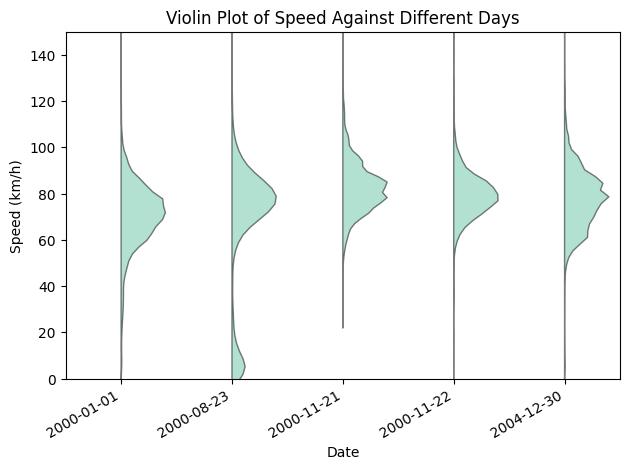

In [84]:
fig, ax1 = plt.subplots(1,1)
violinplot(data=speed_list,ax=ax1 , labels=date_list, side='right', show_boxplot=False)
plt.title('Violin Plot of Speed Against Different Days')
plt.setp(ax1, ylim=[0,150], xlabel = 'Date', ylabel = 'Speed (km/h)')
fig.tight_layout()
fig.autofmt_xdate()
plt.show()

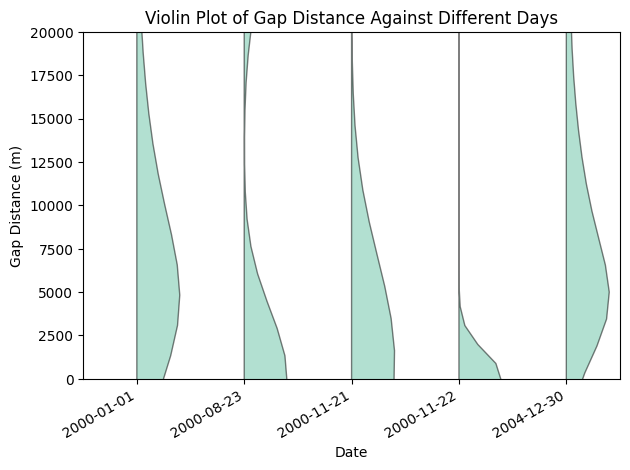

In [83]:
fig, ax1 = plt.subplots(1,1)
violinplot(data=gap_list, ax=ax1, labels=date_list, side='right', show_boxplot=False)
plt.setp(ax1, ylim=[0,20000], xlabel = 'Date', ylabel = 'Gap Distance (m)')
plt.title('Violin Plot of Gap Distance Against Different Days')
fig.tight_layout()
fig.autofmt_xdate()
plt.show()

## Hourly Vehicular Flow

#### This assumes that all data are measured from the same bridge. Since for different bridges, the number of lanes would affect the expected vehicular flow.

### in Unit of Minutes

In [10]:
from datetime import time as t
def generate_time(time_list):
    for h in range(24):
        for m in range(60):
            time_list.append(t(h,m).strftime("%H:%M"))
    return


def vehicular_flow_in_minutes_setup():
    # Create the Time column, where it is in the string format of hour:minute in 1 minute increments
    all_data['Time'] = all_data['Date + Time'].dt.round('1min')
    all_data['Time'] = all_data['Time'].dt.strftime("%H:%M")

    # Make a time list to store all the x data from 00:00 to 23:59
    time_list = []
    generate_time(time_list)
    dict = {"Time": time_list}

    # Loops over the number of recorded dates
    total_entries = 0
    for date in date_list:
        vehicle_flow = []
        # Loops over each minute
        for time in time_list:
            # Tallies the number of vehicle that is recorded in that minute. -> convert the unit from veh/min to veh/hr
            # ? Times 60 for the total numebr of cars to convert: cars per min to cars per hour
            vehicle_flow.append(len(all_data[(all_data['Date']==date) & (all_data['Time']==time)].index) * 60)

        dict[date] = vehicle_flow
        for item in vehicle_flow:
            total_entries += item / 60

    VF_testing = pd.DataFrame(dict)
    return VF_testing, time_list

In [11]:
def vehicular_flow_in_minutes():
    VF_testing, time_list = vehicular_flow_in_minutes_setup()
    for date in date_list:
        # removes the time data for when there is no vehicle recorded
        tmp = np.array(VF_testing[date].astype(float))
        tmp[tmp==0] = np.nan
        plt.plot(VF_testing['Time'], VF_testing[date], label=date)
    plt.xticks(time_list[::60], rotation=70)
    plt.legend()
    plt.grid()
    plt.xlabel('Time of Day')
    plt.ylabel('Vehicular Flow (veh/h)')
    plt.title('Variations in Vehicular Flow Across Different Times of Day')
    plt.tight_layout()
    plt.show()
    return
# vehicular_flow_in_minutes()

In [12]:

def vehicular_flow_in_minutes_scatter_plot():
    VF_testing, time_list = vehicular_flow_in_minutes_setup()

    for date in date_list:
        tmp = np.array(VF_testing[date].astype(float))
        tmp[tmp==0] = np.nan
        plt.scatter(VF_testing['Time'], tmp, label=date)
        # plt.plot(VF_testing['Time'], VF_testing[date], label=date)
    plt.xticks(time_list[::60], rotation=70)
    plt.legend()
    plt.grid()
    plt.xlabel('Time of Day')
    plt.ylabel('Vehicular Flow (veh/h)')
    plt.title('Variations in Vehicular Flow Across Different Times of Day')
    plt.tight_layout()
    plt.show()
    return
# vehicular_flow_in_minutes_scatter_plot()

### In Unit of Hours

In [88]:
from datetime import time as t

def vehicular_flow_in_hours_setup():
        
    def generate_time(time_list):
        for h in range(24):
            time_list.append(t(h).strftime("%H"))
        return

    # Create the Time column, where it is in the string format of hour:minute in 1 minute increments
    all_data['Time'] = all_data['Date + Time'].dt.floor('h')
    all_data['Time'] = all_data['Time'].dt.strftime("%H")

    # Make a time list to store all the x data from 00:00 to 23:59
    time_list = []
    generate_time(time_list)
    dict = {"Time": time_list}

    # Loops over the number of recorded dates
    for date in date_list:
        vehicle_flow = []
        # Loops over each minute
        for time in time_list:
            # Tallies the number of vehicle that is recorded in that minute. -> convert the unit from veh/min to veh/hr
            # ? Times 60 for the total numebr of cars to convert: cars per min to cars per hour
            tmp = all_data[(all_data['Date']==date) & (all_data['Time']==time)]
            hourly_flow = len(tmp.index)
            if hourly_flow < 100: 
                hourly_flow = 0
            vehicle_flow.append(hourly_flow)
        dict[date] = vehicle_flow
    # print()
    VF_testing = pd.DataFrame(dict)

    # Finding the Average Values
    VF_testing['Total'] = VF_testing.iloc[:,1:6].sum(axis=1)
    VF_testing['Unique Dates'] = VF_testing.iloc[:,1:6].astype(bool).sum(axis=1)

    VF_testing['Average'] = VF_testing['Total'] / VF_testing['Unique Dates'] 
    
    return VF_testing, time_list

24


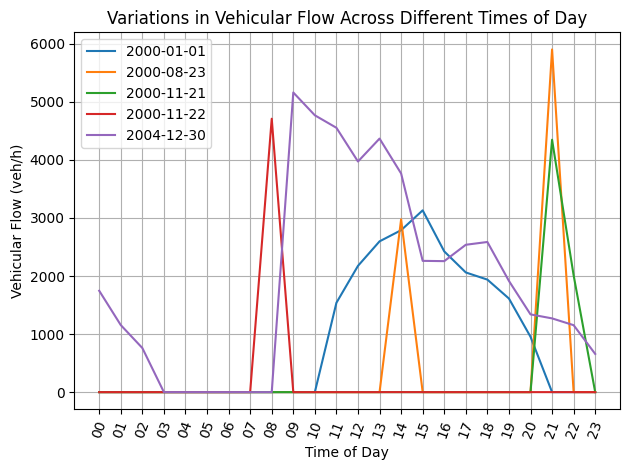

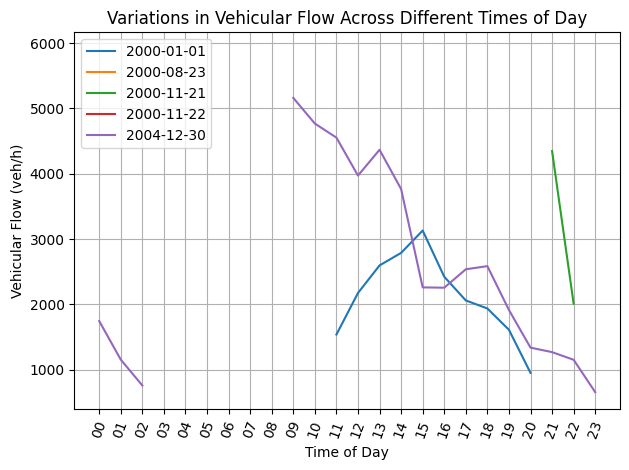

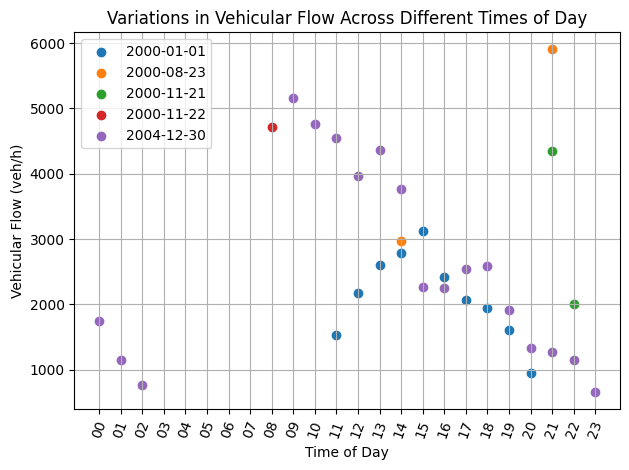

In [14]:
def vehicular_flow_in_hours():

    VF_testing, time_list = vehicular_flow_in_hours_setup()
    print(len(time_list))
    # Print one with the 0 value
    for date in date_list:
        # removes the time data for when there is no vehicle recorded
        tmp = np.array(VF_testing[date].astype(float))
        tmp[tmp==0] = np.nan
        
        plt.plot(VF_testing['Time'], VF_testing[date], label=date)
        # plt.plot(VF_testing['Time'], VF_testing[date], label=date)

    plt.xticks(time_list, rotation=70)
    plt.legend()
    plt.grid()
    plt.xlabel('Time of Day')
    plt.ylabel('Vehicular Flow (veh/h)')
    plt.title('Variations in Vehicular Flow Across Different Times of Day')
    plt.tight_layout()
    plt.show()


    # Print one without 0 values
    for date in date_list:
        # removes the time data for when there is no vehicle recorded
        tmp = np.array(VF_testing[date].astype(float))
        tmp[tmp==0] = np.nan
        
        plt.plot(VF_testing['Time'], tmp, label=date)
        # plt.plot(VF_testing['Time'], VF_testing[date], label=date)

    plt.xticks(time_list, rotation=70)
    plt.legend()
    plt.grid()
    plt.xlabel('Time of Day')
    plt.ylabel('Vehicular Flow (veh/h)')
    plt.title('Variations in Vehicular Flow Across Different Times of Day')
    plt.tight_layout()
    plt.show()
    return

def vehicular_flow_in_hours_scatter_plot():

    VF_testing, time_list = vehicular_flow_in_hours_setup()
    # Scatter Plot
    for date in date_list:
        # removes the time data for when there is no vehicle recorded
        tmp = np.array(VF_testing[date].astype(float))
        tmp[tmp==0] = np.nan
        
        plt.scatter(VF_testing['Time'], tmp, label=date)
        # plt.plot(VF_testing['Time'], VF_testing[date], label=date)

    plt.xticks(time_list, rotation=70)
    plt.legend()
    plt.grid()
    plt.xlabel('Time of Day')
    plt.ylabel('Vehicular Flow (veh/h)')
    plt.title('Variations in Vehicular Flow Across Different Times of Day')
    plt.tight_layout()
    plt.show()
    return

vehicular_flow_in_hours()
vehicular_flow_in_hours_scatter_plot()

#### Now Taking the Average Value across each day

In [15]:
# def generate_time(time_list):
#     for h in range(24):
#         time_list.append(t(h).strftime("%H"))
#     return

# # Create the Time column, where it is in the string format of hour:minute in 1 minute increments
# all_data['Time'] = all_data['Date + Time'].dt.floor('h')
# all_data['Time'] = all_data['Time'].dt.strftime("%H")

# # Make a time list to store all the x data from 00:00 to 23:59
# time_list = []
# generate_time(time_list)
# dict = {"Time": time_list}

# vehicle_flow = []
# # Loops over each minute
# for time in time_list:
#     # Tallies the number of vehicle that is recorded in that minute. -> convert the unit from veh/min to veh/hr
#     # ? Times 60 for the total numebr of cars to convert: cars per min to cars per hour
#     tmp = all_data[all_data['Time']==time]
#     no_of_dates_involved = len(tmp['Date'].unique())
#     if no_of_dates_involved != 0:
#         hourly_flow_value = len(tmp.index) / no_of_dates_involved
#     vehicle_flow.append(hourly_flow_value)
#     dict['Vehicle Flow'] = vehicle_flow

# VF_testing = pd.DataFrame(dict)

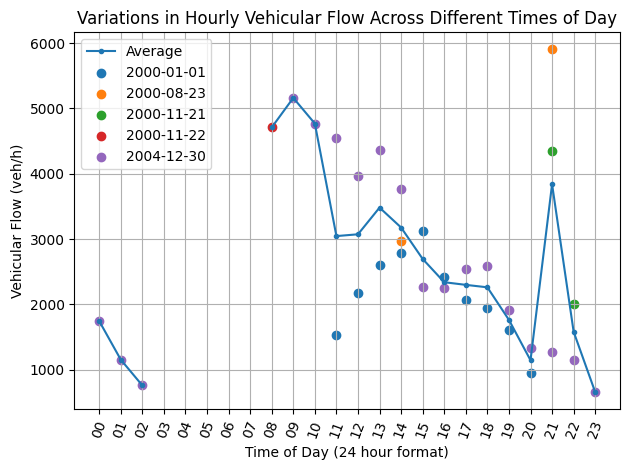

In [100]:
def vehicular_flow_in_hours_with_average_and_scatter():

    VF_testing, time_list = vehicular_flow_in_hours_setup()

    # graph plot the average value
    plt.plot(time_list, VF_testing['Average'],'.-', label='Average')


    # Scatter Plot
    for date in date_list:
        # removes the time data for when there is no vehicle recorded
        tmp = np.array(VF_testing[date].astype(float))
        tmp[tmp==0] = np.nan
        
        plt.scatter(VF_testing['Time'], tmp, label=date)

    plt.xticks(time_list, rotation=70)
    plt.legend(loc=0)
    plt.grid()
    plt.xlabel('Time of Day (24 hour format)')
    plt.ylabel('Vehicular Flow (veh/h)')
    plt.title('Variations in Hourly Vehicular Flow Across Different Times of Day')
    plt.tight_layout()
    plt.show()
    return 

vehicular_flow_in_hours_with_average_and_scatter()


In [97]:
# Defining Data
VF_testing, time_list = vehicular_flow_in_hours_setup()
tmp = VF_testing.dropna(subset=["Average"])

# Building NN 
from keras.models import Sequential
from keras.layers import Dense

X_train       = tmp['Time'].astype(float)
y_train       = tmp['Average'].astype(float)

# essential preprocessing: imputation; substitute any 'NaN' with mean value 
X_train      = X_train.fillna(X_train.mean())


# parameters for keras
input_dim        =  1 # number of neurons in the input layer
n_neurons        = 100       # number of neurons in the first hidden layer
epochs           = 1000      # number of training cycles

# keras model
model = Sequential()        # a model consisting of successive layers
# input layer
model.add(Dense(n_neurons, input_dim=input_dim, 
                kernel_initializer='normal', 
                activation='relu'))
# output layer, with one neuron
model.add(Dense(n_neurons, activation = 'relu'))
model.add(Dense(n_neurons, activation = 'relu'))
model.add(Dense(n_neurons, activation = 'relu'))
model.add(Dense(n_neurons, activation = 'sigmoid'))
model.add(Dense(n_neurons, activation = 'relu'))
model.add(Dense(n_neurons, activation = 'relu'))
model.add(Dense(n_neurons, activation = 'relu'))
model.add(Dense(n_neurons, activation = 'sigmoid'))
model.add(Dense(n_neurons, activation = 'relu'))
model.add(Dense(n_neurons, activation = 'relu'))
model.add(Dense(n_neurons, activation = 'relu'))
model.add(Dense(n_neurons, activation = 'relu'))
model.add(Dense(1, kernel_initializer='normal'))
# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# train the model
history = model.fit(X_train,y_train, epochs=epochs, verbose=1, validation_split=0.1)

# use the model to predict the prices for the test data
y_predicted = model.predict(X_train)


Epoch 1/1000
1/1 [==============================] - 1s 627ms/step - loss: 9398282.0000 - val_loss: 1467810.3750
Epoch 2/1000
1/1 [==============================] - 0s 23ms/step - loss: 9397646.0000 - val_loss: 1467619.0000
Epoch 3/1000
1/1 [==============================] - 0s 22ms/step - loss: 9397170.0000 - val_loss: 1467489.2500
Epoch 4/1000
1/1 [==============================] - 0s 23ms/step - loss: 9396844.0000 - val_loss: 1467343.1250
Epoch 5/1000
1/1 [==============================] - 0s 22ms/step - loss: 9396483.0000 - val_loss: 1467185.8750
Epoch 6/1000
1/1 [==============================] - 0s 22ms/step - loss: 9396094.0000 - val_loss: 1466989.2500
Epoch 7/1000
1/1 [==============================] - 0s 23ms/step - loss: 9395608.0000 - val_loss: 1466746.2500
Epoch 8/1000
1/1 [==============================] - 0s 22ms/step - loss: 9395011.0000 - val_loss: 1466448.7500
Epoch 9/1000
1/1 [==============================] - 0s 24ms/step - loss: 9394283.0000 - val_loss: 1466088.6250


1/1 [==============================] - 0s 21ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


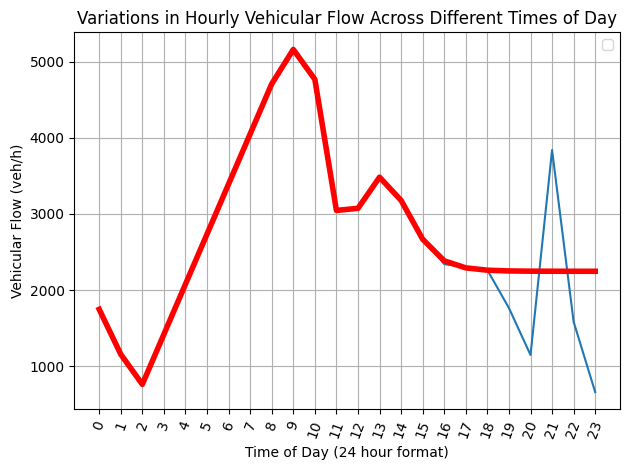

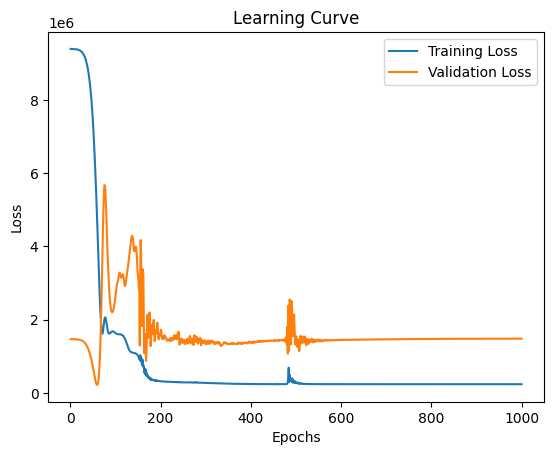

In [98]:
# Compute the output 
y_predicted = model.predict(X_train)

# X_train = sc.inverse_transform(X_train)

# Display the result
plt.plot(X_train, y_train)
plt.plot(X_train, y_predicted, 'r', linewidth=4)
plt.xticks(VF_testing['Time'].astype(int), rotation=70)
plt.legend(loc=0)
plt.grid()
plt.xlabel('Time of Day (24 hour format)')
plt.ylabel('Vehicular Flow (veh/h)')
plt.title('Variations in Hourly Vehicular Flow Across Different Times of Day')
plt.tight_layout()
plt.show()

# Extract the loss values from the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the learning curve
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

## ABANDONED (LDV : HDV at Varying Times of the Day)

In [ ]:
# # print(time_list[::60])
# dict = {"Time": time_list}

# all_data['Hour'] = all_data['Date + Time'].dt.round('1h')
# all_data['Hour'] = all_data['Hour'].dt.strftime("%H:%M")


# for date in date_list:
#     LDV_vehicle_flow = []
#     HDV_vehicle_flow = []
#     for time in time_list:
#         # ? Times 60 for the total numebr of cars to convert: cars per min to cars per hour
#         LDV_vehicle_flow.append(len(all_data[(all_data['Date']==date) & (all_data['Hour']==time) & (all_data['Class'].astype(int)<=2)].index) * 60)
#         HDV_vehicle_flow.append(len(all_data[(all_data['Date']==date) & (all_data['Hour']==time) & (all_data['Class'].astype(int)>2)].index) * 60)

#     dict[date.strftime("%Y%M%D") + 'LDV'] = LDV_vehicle_flow
#     dict[date.strftime("%Y%M%D") + 'HDV'] = HDV_vehicle_flow

#     print(len(vehicle_flow))

#     LDV_HDV_testing = pd.DataFrame(dict)

import numpy as np
import matplotlib.pyplot as plt
from datetime import time as t

def generate_time(time_list):
    for h in range(24):
        for m in range(60):
            time_list.append(t(h,m))
    return

total_list = []
time_list = []
generate_time(time_list)

for date in date_list:
    # print(LDV_HDV_testing[date.strftime("%Y%M%D") + 'LDV'])
    # print(np.array(LDV_HDV_testing[date.strftime("%Y%M%D") + 'LDV']))
    total_list = np.concatenate((total_list, (np.array(LDV_HDV_testing[date.strftime("%Y%M%D") + 'LDV']))))
time_list = time_list * len(date_list)

print(len(total_list))
print(len(time_list))

plt.scatter(total_list, time_list, label=date)
plt.xticks(time_list[::60], rotation=70)
plt.legend()
plt.grid()
plt.xlabel('Time of Day')
plt.ylabel('Vehicular Flow (veh/h)')
plt.title('Variations in Vehicular Flow Across Different Times of Day')
plt.tight_layout()
plt.show()

## LDV to HDV Ratio

In [18]:

# HDV
HDV = all_data.loc[(all_data['Class'].astype(int) > 2)| ((all_data['Class'].astype(int) <= 2) & (all_data['Total Weight'].astype(int) > 6000))]
total_trucks = HDV[HDV.columns[0]].count()
# LDV - Private Vehicle and Motorbikes
PV = all_data.loc[(all_data['Class'].astype(int) <= 2) & (all_data['Total Weight'].astype(int) >= 1500) & (all_data['Total Weight'].astype(int) <= 6000) ]
# PV['Total Weight'].mode
total_cars = PV[PV.columns[0]].count()

# LDV - Motorbike
MB = all_data.loc[(all_data['Class'].astype(int) <= 2) & (all_data['Total Weight'].astype(int) < 1500) ]
total_motorbikes = MB[MB.columns[0]].count()

print([total_trucks,total_cars,total_motorbikes])
print(sum([total_trucks,total_cars,total_motorbikes]))

[32483, 29276, 25743]
87502


[32483, 29276, 25743]


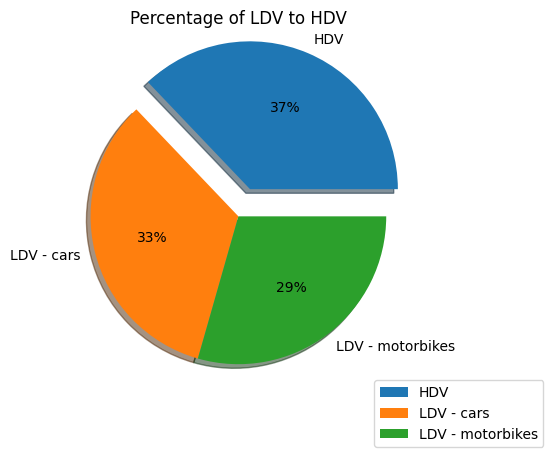

In [19]:
import numpy as np
import matplotlib.pyplot as plt

pie_chart_labels = ['HDV','LDV - cars','LDV - motorbikes']
myexplode = [0.2,0,0]

print([total_trucks,total_cars,total_motorbikes])

plt.pie(np.array([total_trucks,total_cars,total_motorbikes]),labels = pie_chart_labels, explode = myexplode, shadow = True, autopct='%1.0f%%')
plt.legend(title = "", bbox_to_anchor=(1,0), loc="lower right", bbox_transform=plt.gcf().transFigure)
plt.title('Percentage of LDV to HDV')
plt.grid()
plt.show()

## Private Vehicle Weight Distribution. referenced from [Here](https://colab.research.google.com/drive/11A5Td8nxGSbThzL0NPwwv-E5GpBa0Fv9#scrollTo=sMvpBFj5x1L0)

Separating the Private Vehicle from other data

Calculated the Cumulative Probability

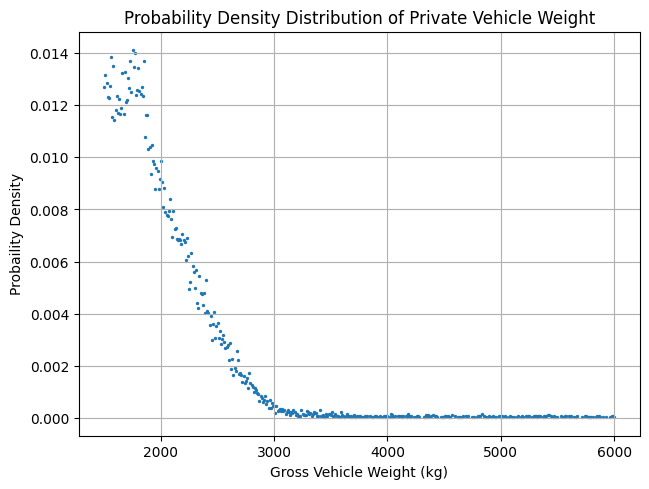

In [43]:
PV_total_weight_and_cumper = pd.DataFrame(PV['Total Weight'].value_counts()).reset_index()
PV_total_weight_and_cumper.columns = ['Total Weight', 'Count']
PV_total_weight_and_cumper['Percentage'] = PV_total_weight_and_cumper['Count'] / total_cars
# Before Sorting
x_data1 = np.log10( PV_total_weight_and_cumper['Total Weight'])
x_data = PV_total_weight_and_cumper['Total Weight']
y_data = PV_total_weight_and_cumper['Percentage']
y_data1 = np.log10(PV_total_weight_and_cumper['Percentage'])


plt.title('Probability Density Distribution of Private Vehicle Weight')
plt.scatter(x_data, y_data , s=2)
plt.tight_layout()
plt.xlabel('Gross Vehicle Weight (kg)')
plt.ylabel('Probaility Density')
plt.grid()
plt.show()

# ! Sort
PV_total_weight_and_cumper = PV_total_weight_and_cumper.sort_values('Total Weight')
PV_total_weight_and_cumper['Cumulative Probability'] = PV_total_weight_and_cumper['Percentage'].cumsum()


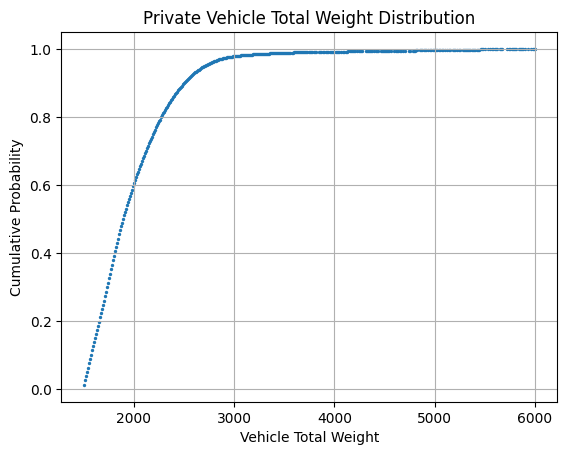

In [21]:
plt.scatter(PV_total_weight_and_cumper['Total Weight'], PV_total_weight_and_cumper['Cumulative Probability'] , s=2)
plt.title('Private Vehicle Total Weight Distribution')
plt.xlabel('Vehicle Total Weight')
plt.ylabel('Cumulative Probability')
plt.grid()
plt.show()

In [22]:
# from sklearn.model_selection import train_test_split
# X_train,X_test,y_train,y_test = train_test_split(x_data,y_data,test_size = 0.1, random_state=42)


In [23]:
from keras.models import Sequential
from keras.layers import Dense

# PV_total_weight_and_cumper['Total Weight'] = np.log(PV_total_weight_and_cumper['Total Weight'])
X_train       = PV_total_weight_and_cumper['Total Weight']
y_train       = PV_total_weight_and_cumper['Cumulative Probability']

# essential preprocessing: imputation; substitute any 'NaN' with mean value 
X_train      = X_train.fillna(X_train.mean())


# parameters for keras
input_dim        =  1 # number of neurons in the input layer
n_neurons        =  50       # number of neurons in the first hidden layer
epochs           = 400       # number of training cycles

# keras model
model = Sequential()        # a model consisting of successive layers
# input layer
model.add(Dense(n_neurons, input_dim=input_dim, 
                kernel_initializer='normal', 
                activation='relu'))
# output layer, with one neuron
model.add(Dense(n_neurons, activation = 'linear'))
model.add(Dense(n_neurons, activation = 'relu'))
model.add(Dense(n_neurons, activation = 'tanh'))
model.add(Dense(n_neurons, activation = 'relu'))
model.add(Dense(n_neurons, activation = 'relu'))
model.add(Dense(n_neurons, activation = 'relu'))
model.add(Dense(n_neurons, activation = 'relu'))
model.add(Dense(1, kernel_initializer='normal'))
# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# train the model
history = model.fit(y_train,X_train, epochs=epochs, verbose=0,validation_split=0.2)

# use the model to predict the prices for the test data
x_predicted = model.predict(y_train)

/Users/felixlaw/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


12/12 [==============================] - 0s 708us/step


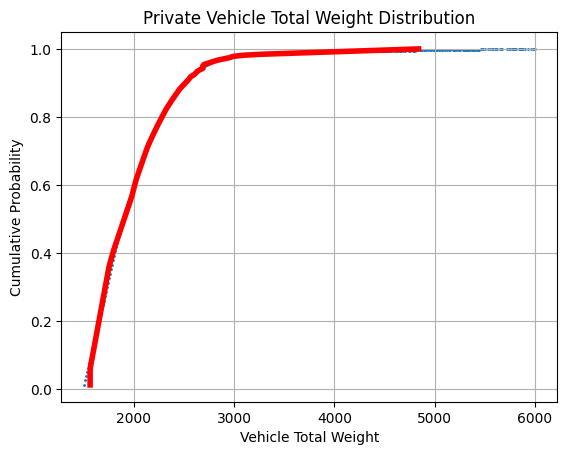

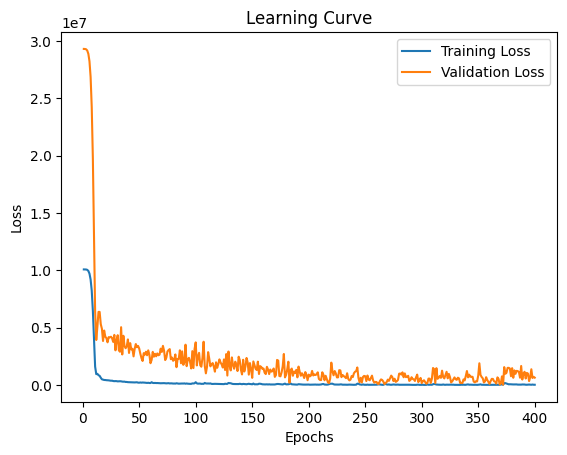

In [24]:
from importlib import reload
plt=reload(plt)
# Display the result
plt.scatter(X_train, y_train, s=1)
plt.plot(x_predicted, y_train, 'r', linewidth=4)
plt.title('Private Vehicle Total Weight Distribution')
plt.xlabel('Vehicle Total Weight')
plt.ylabel('Cumulative Probability')
plt.grid()
plt.show()

# Extract the loss values from the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the learning curve
plt=reload(plt)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()


In [25]:
# history = model.fit(X_train, y_train,validation_data = (X_test,y_test), epochs=300)

# plt.plot(history.history['mean_squared_error'])
# plt.plot(history.history['val_mean_squared_error'])
# plt.title('Model Mean Squared Error')
# plt.ylabel('Mean Squared Error')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

## HDV Weight Distribution. referenced from [Here](https://colab.research.google.com/drive/11A5Td8nxGSbThzL0NPwwv-E5GpBa0Fv9#scrollTo=sMvpBFj5x1L0)

In [26]:
HDV_total_weight_and_cumper = pd.DataFrame(HDV['Total Weight'].value_counts()).reset_index()
HDV_total_weight_and_cumper.columns = ['Total Weight', 'Count']
HDV_total_weight_and_cumper['Percentage'] = HDV_total_weight_and_cumper['Count'] / total_trucks
# Sort it by Weight First or it messes up the Cumu Prob
HDV_total_weight_and_cumper = HDV_total_weight_and_cumper.sort_values("Total Weight")
HDV_total_weight_and_cumper['Cumulative Probability'] = HDV_total_weight_and_cumper['Percentage'].cumsum()

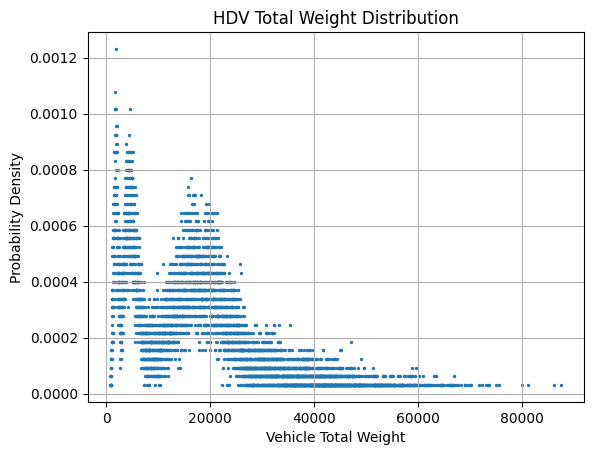

In [46]:
truck_x_data = HDV_total_weight_and_cumper['Total Weight']
truck_y_data = HDV_total_weight_and_cumper['Percentage']

from importlib import reload
plt=reload(plt)

plt.scatter(truck_x_data, truck_y_data , s=2)
plt.title('HDV Total Weight Distribution')
plt.xlabel('Vehicle Total Weight')
plt.ylabel('Probability Density')
plt.grid()
plt.show()

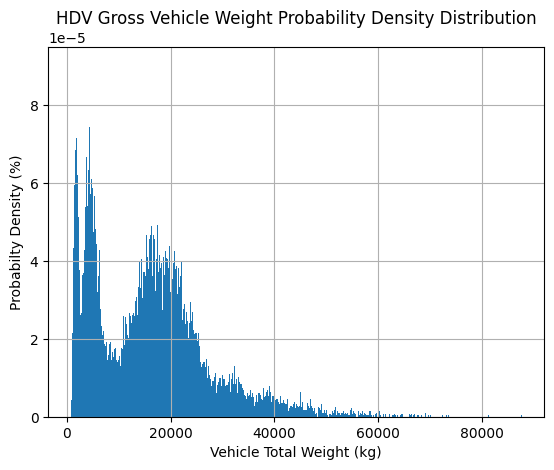

In [62]:
truck_x_data = HDV['Total Weight']
truck_y_data = HDV_total_weight_and_cumper['Count']

from importlib import reload
plt=reload(plt)

plt.hist(x=truck_x_data,bins=1000, density=True)
# truck_x_data = HDV_total_weight_and_cumper['Total Weight']
# plt.scatter(truck_x_data, truck_y_data , s=2)
plt.title('HDV Gross Vehicle Weight Probability Density Distribution')
plt.xlabel('Vehicle Total Weight (kg)')
plt.ylabel('Probabilty Density (%)')
plt.grid()
plt.show()

['Total Weight', 'Count', 'Percentage', 'Cumulative Probability']


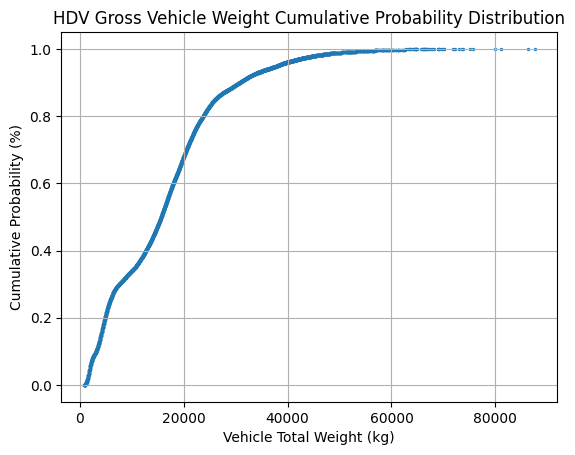

In [63]:
print(list(HDV_total_weight_and_cumper))
truck_x_data = HDV_total_weight_and_cumper['Total Weight']
truck_y_data = HDV_total_weight_and_cumper['Cumulative Probability']
plt.scatter(truck_x_data, truck_y_data , s=2)
plt.title('HDV Gross Vehicle Weight Cumulative Probability Distribution')
plt.xlabel('Vehicle Total Weight (kg)')
plt.ylabel('Cumulative Probability (%)')
plt.grid()
plt.show()

In [29]:
# Create the model 
# Building NN 
from keras.models import Sequential
from keras.layers import Dense

X_train       = truck_x_data
y_train       = truck_y_data

# essential preprocessing: imputation; substitute any 'NaN' with mean value 
X_train      = X_train.fillna(X_train.mean())


# parameters for keras
input_dim        =  1 # number of neurons in the input layer
n_neurons        =  50       # number of neurons in the first hidden layer
epochs           = 400       # number of training cycles

# keras model
model = Sequential()        # a model consisting of successive layers
# input layer
model.add(Dense(n_neurons, input_dim=input_dim, 
                kernel_initializer='normal', 
                activation='relu'))
# output layer, with one neuron
model.add(Dense(n_neurons, activation = 'relu'))
model.add(Dense(n_neurons, activation = 'tanh'))
model.add(Dense(n_neurons, activation = 'relu'))
model.add(Dense(n_neurons, activation = 'relu'))
model.add(Dense(1))
# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# train the model
history = model.fit(y_train,X_train, epochs=epochs, verbose=0, validation_split=0.2)

# use the model to predict the prices for the test data
x_predicted = model.predict(y_train)


147/147 [==============================] - 0s 634us/step


In [30]:
# Training
# model.fit( truck_y_data, truck_x_data, epochs=200, verbose=1)

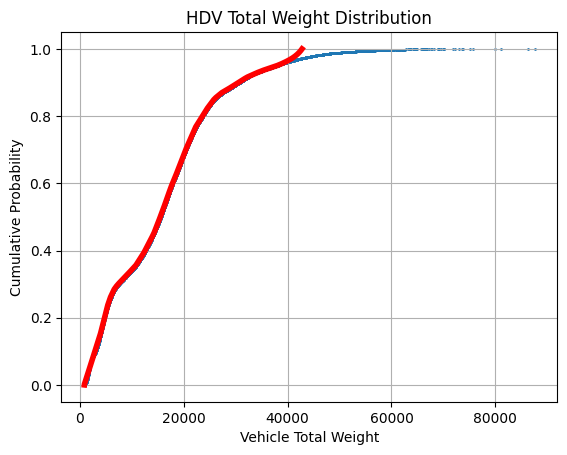

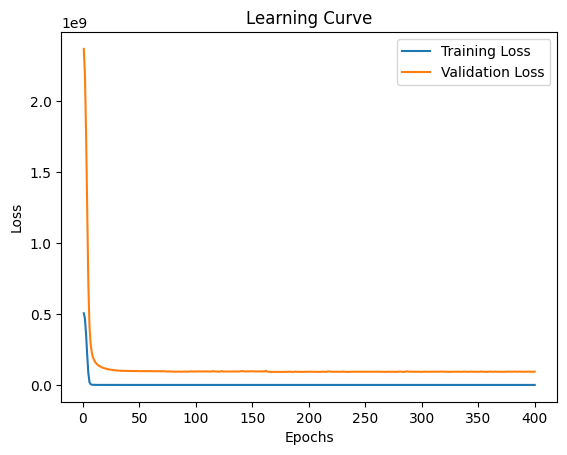

In [31]:
# Compute the output 
# truck_x_predicted = model.predict(truck_y_data)

# Display the result
plt.scatter(truck_x_data[::1], truck_y_data[::1], s=1)
plt.plot(x_predicted, truck_y_data, 'r', linewidth=4)
plt.title('HDV Total Weight Distribution')
plt.xlabel('Vehicle Total Weight')
plt.ylabel('Cumulative Probability')
plt.grid()
plt.show()

# Extract the loss values from the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the learning curve
plt=reload(plt)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [32]:
truck_x_predicted = model.predict(np.array([1]).reshape(-1,1))
print(truck_x_predicted)

1/1 [==============================] - 0s 61ms/step
[[42777.11]]


## Vehicle Class and Axle Weight and Spacing Distribution

In [33]:
all_data.head()
all_data.columns

Index(['Gap Distance', 'Total Weight', 'Bound', 'Date + Time', 'Seq No',
       'Lane', 'Speed', 'Class', 'No of Axle', 'Axle Weight 1',
       'Axle Spacing 1', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13',
       'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17',
       'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21',
       'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25',
       'Unnamed: 26', 'Date', 'Same Bound', 'Same Lane', 'Time'],
      dtype='object')

<Figure size 1500x1000 with 0 Axes>

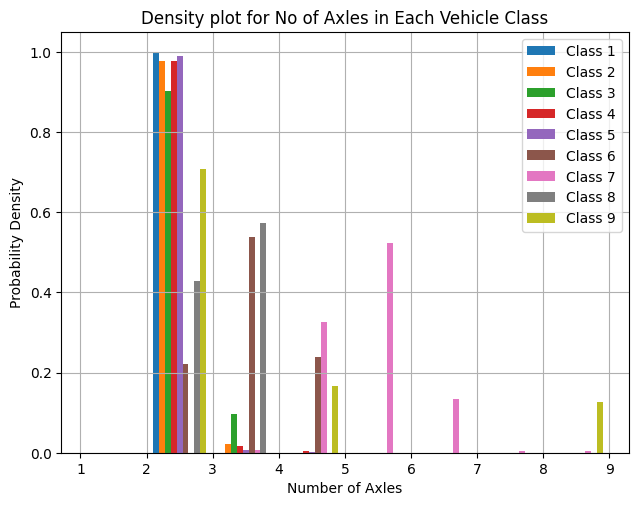

In [110]:
from importlib import reload
plt=reload(plt)
def axle_distribution_for_each_class_plot():
    X = []
    all_vehicle_classes = sorted(all_data['Class'].unique())
    diff_no_of_axles = sorted(all_data['No of Axle'].unique())

    for vehicle_class in all_vehicle_classes:
        tmp = all_data[all_data['Class']== vehicle_class][['Total Weight','Gap Distance','No of Axle']]
        X.append(np.array(tmp['No of Axle']))
    labels = ['Class '+ str(x) for x in all_vehicle_classes]

    plt.figure(figsize=(15, 10))
    fig, ax1 = plt.subplots(1,1)
    plt.tight_layout()
    plt.hist(X,bins=all_vehicle_classes, density=True, histtype='bar', label=labels)
    plt.title('Density plot for No of Axles in Each Vehicle Class')
    plt.ylabel('Probability Density')
    plt.xlabel('Number of Axles')
    plt.legend()
    plt.grid()
    plt.show()
    return
axle_distribution_for_each_class_plot()

In [35]:
from collections import Counter

def axle_distribution_for_each_class() -> pd.DataFrame:
    X = []
    all_vehicle_classes = sorted(all_data['Class'].unique())
    diff_no_of_axles = [1,2,3,4,5,6,7]

    for vehicle_class in all_vehicle_classes:
        tmp = all_data[all_data['Class']== vehicle_class][['Total Weight','Gap Distance','No of Axle']]
        X.append(np.array(tmp['No of Axle']))

    df_no_of_axle = pd.DataFrame({'No of Axle':diff_no_of_axles})
    for i in range(len(X)):
        df_no_of_axle[all_vehicle_classes[i]] = Counter(X[i])
        df_no_of_axle[all_vehicle_classes[i]] = df_no_of_axle[all_vehicle_classes[i]] / df_no_of_axle[all_vehicle_classes[i]].sum()
    df_no_of_axle = df_no_of_axle.fillna(0)
    return df_no_of_axle


### Finding classes within HDV

In [36]:
#within all_data obtain subset with only HDV, with information about the class value -> count all the class values occurances and output as a distribution
# HDV -> Class
def finding_HDV_class_distribution(all_data):

    HDV = all_data.loc[(all_data['Class'].astype(int) > 2)| ((all_data['Class'].astype(int) <= 2) & (all_data['Total Weight'].astype(int) > 6000))]
    all_vehicle_classes = sorted(HDV['Class'].unique())
    print(all_vehicle_classes)

    output = pd.DataFrame({'Class': all_vehicle_classes})

    # for i_class in all_vehicle_classes:
    tmp = Counter(HDV['Class'])
    output['HDV'] = tmp
    output['HDV'] = output['HDV'].fillna(0)

    # finding the probability. 
    sum = output['HDV'].sum()
    output['Probabililty'] = output['HDV'] / sum
    
    output = np.array(output['Probabililty'])

    return output
finding_HDV_class_distribution(all_data)



[1, 2, 3, 4, 5, 6, 7, 8, 9]


array([0.        , 0.00066519, 0.05264492, 0.07260057, 0.16252772,
       0.08653785, 0.1369338 , 0.36487171, 0.12321825])

## Function to find the distribution of the a discrete parameter


In [37]:
# within Key -> GVW
def finding_distribution_from_continuous(vehicle_class_key, vehicle_class_value , total_weight_key):

    # HDV = all_data.loc[(all_data[key].astype(int) == class_number) | (all_data[key].astype(str) == class_number)]
    # all_types_within_table = sorted(HDV[key].unique())

    all_types_within_class_number = sorted(HDV[class_number].unique())
    output = pd.DataFrame({class_number: all_types_within_class_number})

    # for i_class in all_vehicle_classes:
    output[class_number] = Counter(df[class_number])
    output[class_number] = output[class_number].fillna(0)

    # finding the probability. 
    sum = output[class_number].sum()
    output['Probabililty'] = output[class_number] / sum
    
    output = np.array(output['Probabililty'])

    return output



finding_distribution_from_continuous(vehicle_class_key, vehicle_class_value , total_weight_key)

NameError: name 'vehicle_class_key' is not defined

In [ ]:
# * Function Template for finding distribution from dataset, plotting the dataset, and interpolating data

from importlib import reload
import random

def finding_distribution_from_continuous(vehicle_class_key, vehicle_class_value , total_weight_key):
    # making a subset dataframe for the dataset that suit the selection
    tmp = all_data[all_data[vehicle_class_key] == vehicle_class_value]
    tmp = pd.DataFrame(tmp[total_weight_key].value_counts())

    tmp = tmp.sort_values(total_weight_key).reset_index()

    tmp.columns = [total_weight_key, 'Count']
    total_rows = tmp['Count'].sum()
    
    # calculate the percentage and cumulative probability for each dataset
    tmp['Percentage'] = tmp['Count'] / total_rows
    tmp['Cumulative Probability'] = tmp['Percentage'].cumsum()
    return tmp[[total_weight_key, 'Cumulative Probability']]

def plot_distribution(df:pd.DataFrame):
    import matplotlib.pyplot as plt 
    x_axis = df.columns[0]
    y_axis = df.columns[-1]
    plt.scatter(df[x_axis], df[y_axis], s=2)
    # plt.plot(df[x_axis], df[y_axis])
    plt=reload(plt)
    plt.title(f'{x_axis} against {y_axis}')
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.grid()
    plt.show()
    return

def generate_and_interpolate_value(dataframe: pd.DataFrame):
    x_axis = dataframe.columns[0]
    y_axis = dataframe.columns[-1]

    # Generate a random number between 0 and 1
    random_prob = random.random()
    # print(f'{random_prob = }')

    # Sort the dataframe by cumulative probability column
    sorted_df = dataframe.sort_values(y_axis)

    # Find the closest value values based on the random probability
    closest_values = []
    closest_values.append(sorted_df[(sorted_df[y_axis] <= random_prob)].tail(1)[x_axis].values[0])
    closest_values.append(sorted_df[(sorted_df[y_axis] >= random_prob)].tail(1)[x_axis].values[0])
    # print(sorted_df[(sorted_df[y_axis] <= random_prob)].tail(1))
    # print(sorted_df[(sorted_df[y_axis] >= random_prob)].head(1))
    # print(closest_values)

    # Calculate the value value using linear interpolation
    interpolated_value = closest_values[0] + (closest_values[1] - closest_values[0]) * random_prob

    print(f'{random_prob = }, {interpolated_value = }')

    return interpolated_value

# Usage:  
        # tmp = finding_distribution_from_continuous(vehicle_class_key, vehicle_class_value , total_weight_key)

vehicle_class_key = 'Class'
vehicle_class_value = 2
total_weight_key = 'Total Weight'
tmp = finding_distribution_from_continuous(vehicle_class_key, vehicle_class_value , total_weight_key)
plot_distribution(tmp)
generate_and_interpolate_value(tmp)

      Total Weight  Cumulative Probability
0              610                0.000035
1              620                0.173659
2              640                0.173677
3              650                0.173694
4              660                0.173747
...            ...                     ...
1458         26950                0.999929
1459         27380                0.999947
1460         27730                0.999965
1461         28220                0.999982
1462         32750                1.000000

[1463 rows x 2 columns]


In [ ]:
all_data.columns

Index(['Gap Distance', 'Total Weight', 'Bound', 'Date + Time', 'Seq No',
       'Lane', 'Speed', 'Class', 'No of Axle', 'Axle Weight 1',
       'Axle Spacing 1', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13',
       'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17',
       'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21',
       'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25',
       'Unnamed: 26', 'Date', 'Same Bound', 'Same Lane', 'Time'],
      dtype='object')

In [ ]:
for i in range(11,27):
    if i % 2 == 0:
        new_column_name = 'Axle Spacing ' + str(i+1)
    else:
        new_column_name = 'Axle Weight ' + str(i+1)
    column_name = 'Unnamed: ' + str(i)
    all_data[column_name] = 



## LSTM for Traffic Flow Predictions

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Load the traffic data from a CSV file
data = pd.read_csv('Lantau Link Yearly Traffic.csv').astype(int)
data = data.transpose()
data = data.reset_index()

data = data.rename(columns={'index':'traffic_flow'})
data['Year'] = range(1997,2023)
print(data)

for j in range(5,15):
    # Preprocess the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data['traffic_flow'].values.reshape(-1, 1))

    # Split the data into training and testing sets
    train_size = int(len(scaled_data) * 0.8)
    train_data = scaled_data[:train_size]
    test_data = scaled_data[train_size:]
    print(f'{train_data = }, {test_data = }')

    # Define the number of time steps to use for prediction
    time_steps = j

    # Function to create input sequences and corresponding labels
    def create_sequences(data, time_steps):
        X, y = [], []
        for i in range(len(data) - time_steps):
            X.append(data[i:i+time_steps])
            y.append(data[i+time_steps])
        print(len(X),len(y))
        return np.array(X), np.array(y)

    # Create training and testing sequences
    X_train, y_train = create_sequences(train_data, time_steps)
    X_test, y_test = create_sequences(test_data, time_steps)

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(64, input_shape=(time_steps, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Set up early stopping to prevent overfitting
    # early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model
    print(f'{X_train =}')
    print(f'{y_train =}')
    model.fit(X_train, y_train, epochs=100)
    # model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, callbacks=[early_stopping])

    # Make predictions on the test set
    predicted_data = model.predict(X_test)

    # Inverse transform the predictions and the actual values
    predicted_data = scaler.inverse_transform(predicted_data)
    y_test = scaler.inverse_transform(y_test)

    # Calculate the root mean squared error (RMSE)
    rmse = np.sqrt(np.mean((predicted_data - y_test) ** 2))
    print(f"{time_steps = }Root Mean Squared Error (RMSE): {rmse}")

   traffic_flow  Year
0       2066873  1997
1       9405440  1998
2      13600030  1999
3      13852104  2000
4      13877867  2001
5      15030028  2002
6      14799159  2003
7      17553296  2004
8      18793501  2005
9      19783091  2006
10     20784378  2007
11     20651031  2008
12     20063672  2009
13     22672072  2010
14     23923671  2011
15     25139219  2012
16     26709653  2013
17     28386792  2014
18     30651688  2015
19     32121743  2016
20     34077056  2017
21     35327648  2018
22     35560953  2019
23     19849136  2020
24     17686845  2021
25     18825001  2022
train_data = array([[0.        ],
       [0.21910042],
       [0.34433419],
       [0.35186012],
       [0.3526293 ],
       [0.38702824],
       [0.38013541],
       [0.46236299],
       [0.49939058],
       [0.5289358 ],
       [0.55883025],
       [0.55484904],
       [0.53731283],
       [0.61518928],
       [0.65255705],
       [0.68884848],
       [0.73573539],
       [0.78580809],
       [0.85342

ValueError: Expected input data to be non-empty.